In [16]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy as sp
from scipy.special import erf
import math
import networkx as nx

In [17]:
def _auto_positions(G):
    """
    Choose a symmetric layout automatically.
    Tries Graphviz; else uses KK / circular / spring.
    Uses an undirected copy for nicer symmetry.
    """
    U = nx.Graph(G)  # undirected for layout symmetry

    # 1) Try Graphviz layouts if available
    try:
        from networkx.drawing.nx_pydot import graphviz_layout
        if nx.is_directed_acyclic_graph(G):
            return graphviz_layout(U, prog="dot")   # layered symmetry
        return graphviz_layout(U, prog="neato")     # force-directed symmetry
    except Exception:
        pass

    # 2) Special-case bipartite graphs
    try:
        from networkx.algorithms import bipartite
        if bipartite.is_bipartite(U):
            left = next(iter(bipartite.sets(U)))
            return nx.bipartite_layout(U, left)
    except Exception:
        pass

    # 3) If graph is close to a cycle/clique, circular looks best
    if U.number_of_edges() >= U.number_of_nodes():
        return nx.circular_layout(U)

    # 4) General nice default
    return nx.kamada_kawai_layout(U)

def intersection_graph(
    blocks,
    title,
    use_latex=False,
    layout="auto",
    seed=7,
    ax=None,
    figsize=(4, 4),
    dpi=300,
    show=False,
    return_pos=False,
    node_style=None,
    edge_style=None,
):
    """
    Draw the intersection graph and return (fig, ax[, pos]).
    - Provide `ax` to draw in an existing subplot (for grids/tables).
    - Set `show=True` if you still want plt.show().
    - Set `return_pos=True` to also get the layout positions.
    - `node_style` / `edge_style` let you override drawing kwargs.
    """
    # Keep LaTeX off by default (safer in many envs)
    mpl.rcParams["text.usetex"] = bool(use_latex)
    mpl.rcParams["mathtext.fontset"] = "cm"

    edges = list(blocks.keys())
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Choose layout
    if layout == "auto":
        pos = _auto_positions(G)
    elif layout in {"dot", "neato"}:
        try:
            from networkx.drawing.nx_pydot import graphviz_layout
            prog = "dot" if layout == "dot" else "neato"
            pos = graphviz_layout(nx.Graph(G), prog=prog)
        except Exception:
            pos = nx.kamada_kawai_layout(G)
    elif layout == "circular":
        pos = nx.circular_layout(G)
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    else:  # spring as last resort
        pos = nx.spring_layout(G, seed=seed)

    # Figure / axis management
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi, constrained_layout=True)
        created_fig = True
    else:
        fig = ax.figure

    # Defaults with optional overrides
    edge_kw = dict(arrows=True, arrowstyle='-|>', arrowsize=15,
                   width=1, connectionstyle="arc3,rad=0.1", edge_color="black")
    node_kw = dict(node_size=600, node_color="#E9EEF7",
                   edgecolors="blue", linewidths=1)
    if edge_style: edge_kw.update(edge_style)
    if node_style: node_kw.update(node_style)

    # Draw
    nx.draw_networkx_edges(G, pos, ax=ax, **edge_kw)
    nx.draw_networkx_nodes(G, pos, ax=ax, **node_kw)

    def fmt(lbl): return f"${lbl}$" if use_latex else str(lbl)
    nx.draw_networkx_labels(
        G, pos, labels={n: fmt(n) for n in G.nodes()},
        font_size=12, ax=ax
    )

    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    fig.tight_layout()

    if show:
        plt.show()

    if return_pos:
        return fig, ax, pos
    return fig, ax


In [18]:
def RELU(x):
    return np.maximum(x, 0)

def ABS(x):
    return np.abs(x)

def GELU(x):
    return 0.5 * x * (1.0 + erf(x / np.sqrt(2.0)))

def LINEAR(x):
    return x

def BINARY(x):
    return np.where(x >= 0, 1, 0)

def SIGMOID(x):
    return 1 / (1 + np.exp(-x))

def TANH(x):
    return np.tanh(x)

def SOFTSIGN(x):
    return x / (1 + np.abs(x))

def SOFTPLUS(x):
    return np.log1p(np.exp(x))

def LEAKY_RELU(x):
    return np.where(x > 0, x, 0.01 * x)

def SILU(x):
    return x / (1 + np.exp(-x))

def ELISH(x):
    return np.where(x < 0,
                    (np.exp(x) - 1) / (1 + np.exp(-x)),
                    x / (1 + np.exp(-x)))

def GAUSSIAN(x):
    return np.exp(-x**2)

def SINUSOIDAL(x):
    return np.sin(x)

In [19]:
## HELPER

def is_zero_numeric(A, tol=1e-12):
    """Return True if the numeric matrix/vector is zero up to tol."""
    return np.linalg.norm(np.asarray(A, dtype=float)) <= tol

def chop_matrix(B, tol=1e-12):
    """Return a SymPy matrix with tiny entries set to 0."""
    B = sp.Matrix(B)
    return B.applyfunc(lambda x: 0 if abs(float(x)) < tol else x)

## Calculation Code

def q_matrix(n: int, normalise: bool = False, j_start: int = 1):
    '''
    Change of basis matrix to R^n
    '''
        
    j = sp.symbols('j', integer=True)
    k = sp.symbols('k', integer=True)
    pi = sp.pi
    
    cols = []
    labels = [] 
    
    def col(vec):
        return sp.Matrix(vec)
    
    # j-range
    js = list(range(j_start, j_start + n))
    
    # w_0: trivial rep
    w0 = [sp.Integer(1) for _ in js]
    cols.append(col(w0))
    labels.append(("L_0", "w_0"))
    
    # 2D rotation pairs
    max_k = (n - 1) // 2 
    for kk in range(1, max_k + 1):
        w_plus = [ -sp.sin(2*pi*jj*kk/n) for jj in js ]  # (-sin)
        w_minus = [  sp.cos(2*pi*jj*kk/n) for jj in js ]  # (cos)
        cols.append(col(w_plus))
        labels.append((f"L_{kk}", f"w_plus_{kk}"))
        cols.append(col(w_minus))
        labels.append((f"L_{kk}", f"w_minus_{kk}"))
    
    # w_m: sign rep if n even: k = n/2
    if n % 2 == 0:
        m = n // 2
        w_m = [ sp.cos(sp.pi*jj) for jj in js ]  # (-1)^j
        cols.append(col(w_m))
        labels.append((f"L_{m}", f"w_{m}"))
    

    Q = sp.Matrix.hstack(*cols)
    
    # Normalisation of columns (optional)
    if normalise:
        Qn_cols = []
        new_labels = []
        for c, lab in zip(Q.T, labels):
            norm = sp.sqrt(sp.nsimplify(sum(ci**2 for ci in c)))
            norm = sp.simplify(norm)

            if norm != 0:
                Qn_cols.append(c / norm)
            else:
                Qn_cols.append(c)
            new_labels.append(lab)
        Q = sp.Matrix.hstack(*Qn_cols)
        labels = new_labels
    
    return Q, labels


def m_matrix(n: int):
    """
    Regular rep of C_n in permutation basis.
    """

    M = sp.zeros(n, n)
    for j in range(n): 
        i = (j + 1) % n
        M[i, j] = 1

    return M


def d_matrix(n:int):
    """Diagonal D so that Q^{-1} = D Q^T"""
    entries = [sp.Rational(1, n)]  # trivial column
    for _ in range((n - 1)//2):    # each 2D pair
        entries += [sp.Rational(2, n), sp.Rational(2, n)]
    if n % 2 == 0:                 # sign column
        entries.append(sp.Rational(1, n))
    return sp.diag(*entries)


def indices_by_rep(labels):
    """
    Group Q's columns by simple L.
    labels is the second return of q_matrix(n, ...).
    Returns: dict like {'L_0':[0], 'L_1':[1,2], 'L_2':[3,4], 'L_sign':[...]}
    """
    idx = {}
    for j,(L,_) in enumerate(labels):
        idx.setdefault(L, []).append(j)
    return idx



def inclusion_matrix(Q, cols):
    """i_L: R^{dim L} -> R^n (select the columns for L)."""
    return Q[:, cols]



def projection_matrix(Q, D, cols):
    """p_L: R^n -> R^{dim L} (select the matching rows of Q^{-1} = D Q^T)."""
    Q_inv = D * Q.T
    return Q_inv[cols, :]



def activation_func_block(Q, D, byL, src_L, dst_L, activation_func=RELU,  test_vectors=None):
    """
    Compute the block map p o f o i by evaluating on basis/test vectors.
    Returns a matrix of shape (dim dst_L, dim src_L) if using the canonical basis of L,
    or a list of column-vectors if you pass custom test_vectors.
    """
    iL = inclusion_matrix(Q, byL[src_L])    # (n, d_src)
    pK = projection_matrix(Q, D, byL[dst_L])# (d_dst, n)

    d_src = iL.shape[1]

    if test_vectors is None:
        test_vectors = [sp.Matrix.eye(d_src)[:, j] for j in range(d_src)] # standard basis of R^n

    cols = []
    for v in test_vectors:
        x = iL * v                           # embed in R^n
        x_np = np.array(x, dtype=float).reshape(-1)
        y_np = activation_func(x_np)                    # apply activation function coordinatewise
        y = sp.Matrix(y_np)                  # back to sympy
        out = pK * y                         # project to dst_L
        out = chop_matrix(out, tol=1e-12)
        cols.append(out)

    if test_vectors is None or all(vec.shape == (d_src,1) for vec in test_vectors):
        B = sp.Matrix.hstack(*cols)          # (d_dst, d_src)
        B = chop_matrix(B, tol=1e-12)
        return B
    return cols

$\text{Example}: C_n$

C:\Users\Mani\AppData\Local\Temp\ipykernel_2284\1954042609.py:108: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmpkbapamrg\\tmp3_k0gua2'] returned code: 3221225477

stdout, stderr:
 b''
b''

"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmp5xqkbibq\\tmpny9p7qgj'] returned code: 3221225477

stdout, stderr:
 b''
b''

"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmp_2w5vkzd\\tmp03qv_q_8'] returned code: 3221225477

stdout, stderr:
 b''
b''

"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmp6c95twci\\tmp34u0i71e'] returned code: 3221225477

stdout, stderr:
 b''
b''

"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmpcw_tpuhq\\tmpvn2ymrkd'] returned code: 3221225477

stdout, stderr:
 b''
b''

"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmpkhng759a\\tmpt5xu5_t5'] returned code: 3221225477

stdout, stderr:
 b''
b''

"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmp9gtxo_ea\\tmp4ypldt4e'] returned code: 32

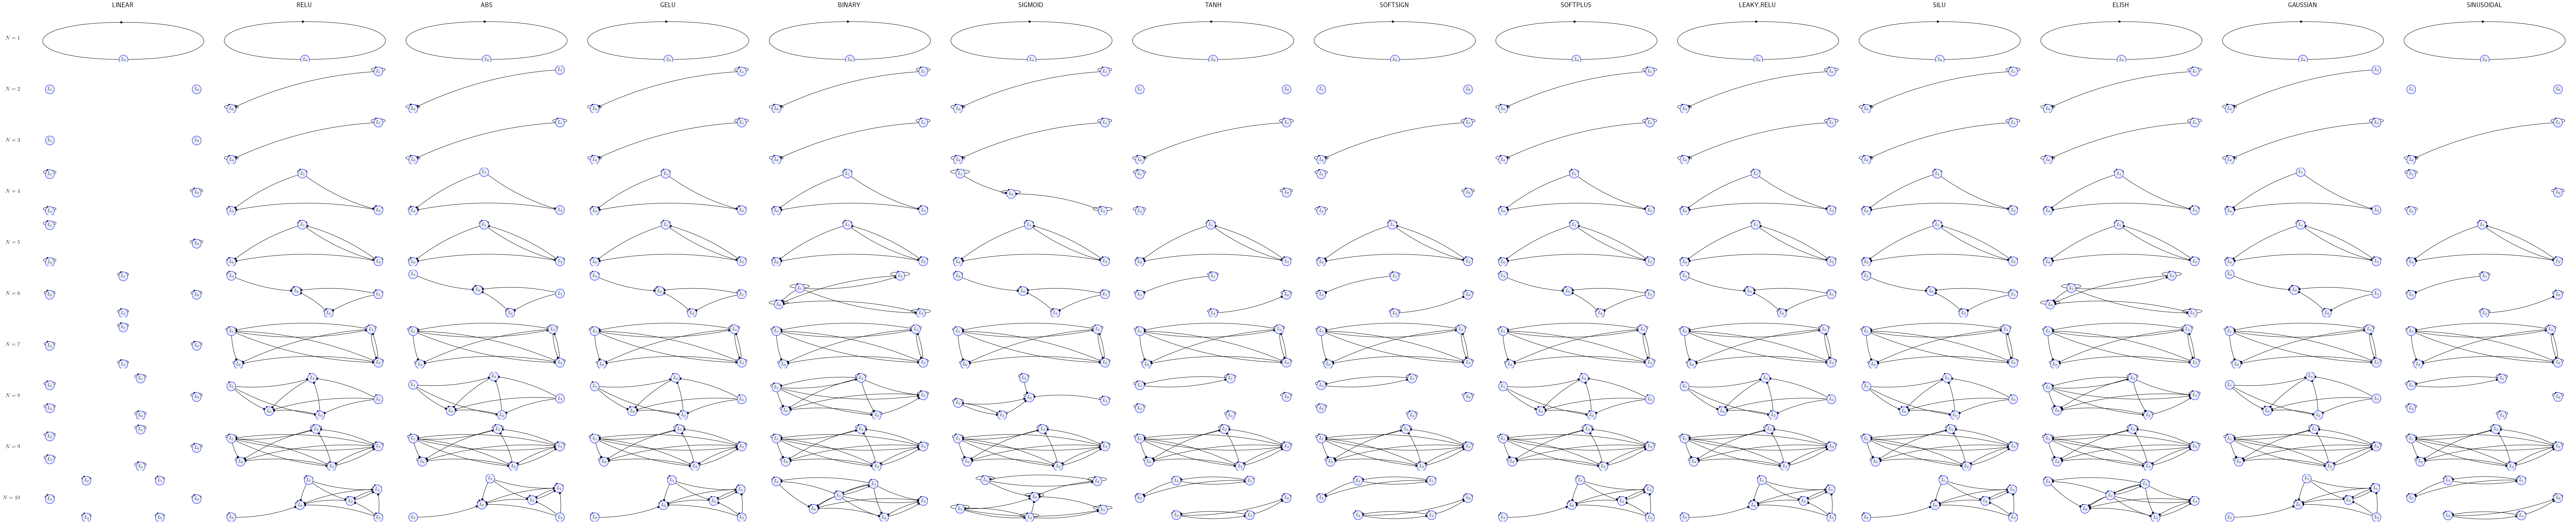

In [24]:
N = 10
activ_funcs = [LINEAR, RELU, ABS, GELU, BINARY, SIGMOID, TANH, SOFTSIGN, SOFTPLUS, LEAKY_RELU, SILU, ELISH, GAUSSIAN, SINUSOIDAL]


fig, axs = plt.subplots(N, len(activ_funcs), figsize=(7*len(activ_funcs), 2*N), constrained_layout=True)


for j, activ_func in enumerate(activ_funcs):
    for i, n in enumerate(range(1, N+1)):
        Q, labels = q_matrix(n)
        M = m_matrix(n)
        D = d_matrix(n)
        byL = indices_by_rep(labels)

        blocks = {}
        for Ls in byL:
            for Lk in byL:
                B = activation_func_block(Q, D, byL, Ls, Lk, activation_func=activ_func)
                if not is_zero_numeric(B, tol=1e-12):
                    blocks[(Ls, Lk)] = B

        ax = axs[i, j]
        intersection_graph(
            blocks,
            use_latex=True,
            title=None,          
            layout="auto",
            ax=ax
        )

        ax.set_xticks([])
        ax.set_yticks([])
        for side in ("top", "right", "bottom", "left"):
            ax.spines[side].set_visible(False)

        if j == 0:
            ax.text(-0.08, 0.5, rf"$N={n}$", transform=ax.transAxes,
                    ha="right", va="center", fontsize=15)

        if i == 0:
            ax.set_title(f"{activ_func.__name__}", fontsize=18, pad=20)

# plt.subplots_adjust(wspace=0.2, hspace=0.7)
plt.savefig("c_n.png", dpi=300)
plt.show()
